In [1]:
# Copyright (c) 2019, NVIDIA CORPORATION. All rights reserved.
#
# This work is licensed under the Creative Commons Attribution-NonCommercial
# 4.0 International License. To view a copy of this license, visit
# http://creativecommons.org/licenses/by-nc/4.0/ or send a letter to
# Creative Commons, PO Box 1866, Mountain View, CA 94042, USA.

"""Minimal script for generating an image using pre-trained StyleGAN generator."""

import os
import pickle
import numpy as np
import PIL.Image
import dnnlib
import dnnlib.tflib as tflib
import config
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, Dense, Lambda
import tensorflow as tf
import tensorboard
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import cv2
import model_utils
from training import misc

In [2]:
# Initialize TensorFlow.
tflib.init_tf()

# Load pre-trained network.
url = 'https://drive.google.com/uc?id=1MEGjdvVpUsu1jB4zrXZN7Y4kBBOzizDQ' # karras2019stylegan-ffhq-1024x1024.pkl
with dnnlib.util.open_url(url, cache_dir=config.cache_dir) as f:
    _G, _D, Gs = pickle.load(f)
    # _G = Instantaneous snapshot of the generator. Mainly useful for resuming a previous training run.
    # _D = Instantaneous snapshot of the discriminator. Mainly useful for resuming a previous training run.
    # Gs = Long-term average of the generator. Yields higher-quality results than the instantaneous snapshot.

In [3]:
## Print network details.

In [4]:
Gs.print_layers()
print(type(Gs).__name__)
print(Gs.components)


Gs                              Params    OutputShape          WeightShape     
---                             ---       ---                  ---             
latents_in                      -         (?, 512)             -               
labels_in                       -         (?, 0)               -               
lod                             -         ()                   -               
dlatent_avg                     -         (512,)               -               
G_mapping/latents_in            -         (?, 512)             -               
G_mapping/labels_in             -         (?, 0)               -               
G_mapping/PixelNorm             -         (?, 512)             -               
G_mapping/Dense0                262656    (?, 512)             (512, 512)      
G_mapping/Dense1                262656    (?, 512)             (512, 512)      
G_mapping/Dense2                262656    (?, 512)             (512, 512)      
G_mapping/Dense3                262656 

In [5]:
# Specify number of images generated
num_imgs = 10

# Pick latent vector

In [6]:

rnd = np.random.RandomState()
latents = rnd.randn(num_imgs, Gs.input_shape[1])

# Generate random images

In [7]:
# Generate image.
fmt = dict(func=tflib.convert_images_to_uint8, nchw_to_nhwc=True)

images = Gs.run(latents, None, truncation_psi=0.7, randomize_noise=True, output_transform=fmt)

## Show Random Generated Images 

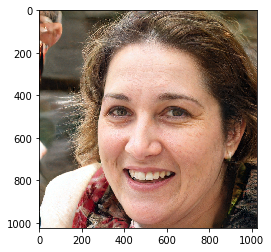

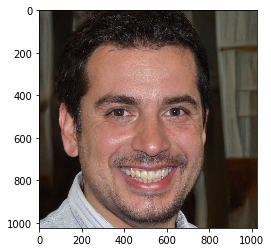

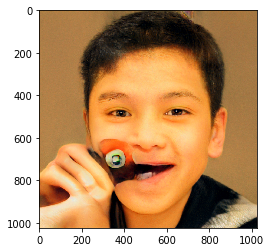

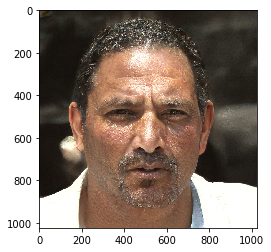

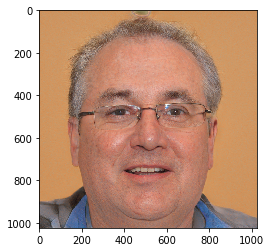

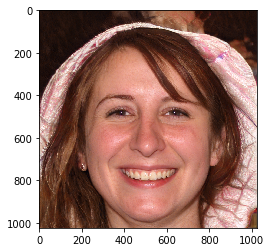

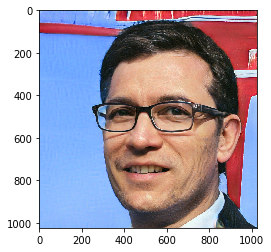

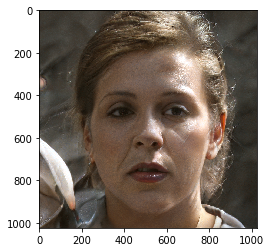

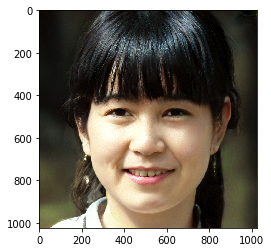

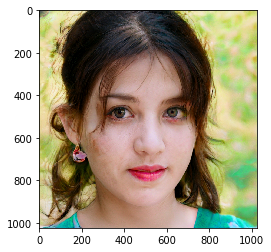

In [8]:

for img in images:
    #print(img)
    plt.figure()
    plt.imshow(img)

## Generate Image from learned Mapping 

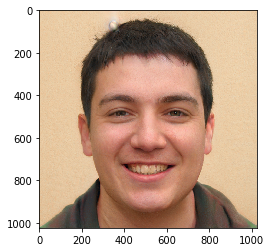

In [9]:
# Load latent vector in
latent_vector = np.load(os.path.join(os.getcwd(), 'new_latent_weights.npy'))
pred_img = Gs.run(latent_vector, None, truncation_psi=0.7, randomize_noise=True, output_transform=fmt)
plt.figure()
plt.imshow(pred_img[0])

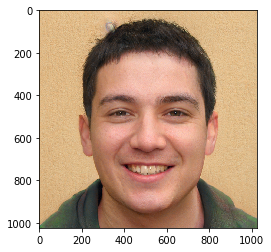

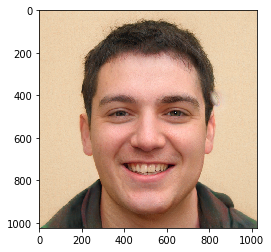

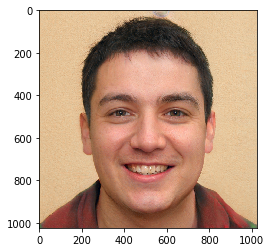

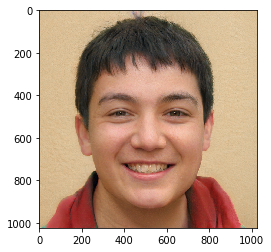

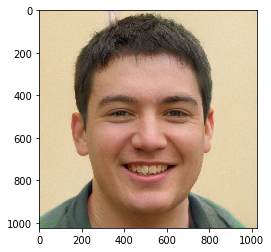

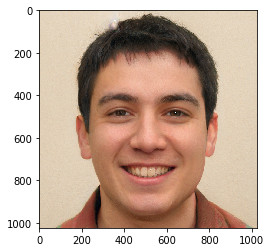

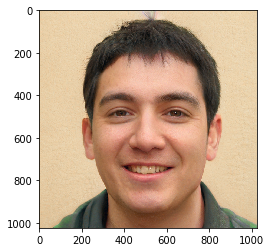

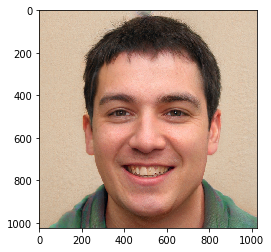

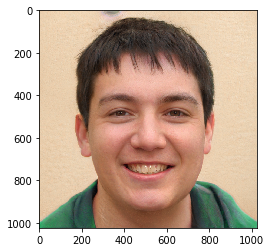

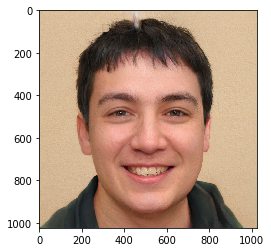

In [10]:
for i in range(10):
    new_latent = latent_vector + (rnd.randn(num_imgs, Gs.input_shape[1])*0.003)
    pred_img = Gs.run(new_latent, None, truncation_psi=0.7, randomize_noise=True, output_transform=fmt)
    plt.figure()
    plt.imshow(pred_img[0])

In [14]:
latent_save_path = 'latent_prediction_1024.npy'
#latent_save_path = 'latent_prediction_1024.npy'


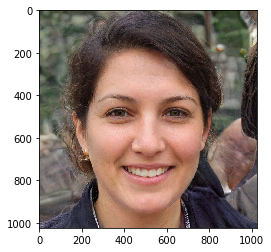

In [15]:
latent_vector = np.load(os.path.join(os.getcwd(), latent_save_path))
pred_img = Gs.run(latent_vector, None, truncation_psi=0.7, randomize_noise=True, output_transform=fmt)
plt.figure()
plt.imshow(pred_img[0])

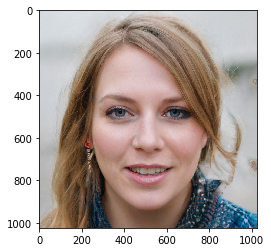

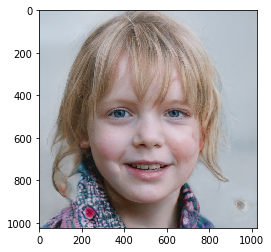

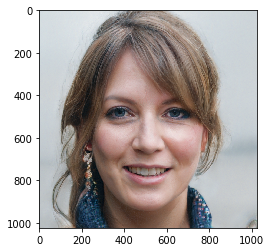

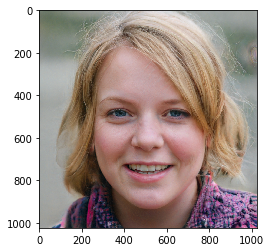

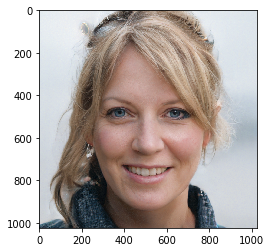

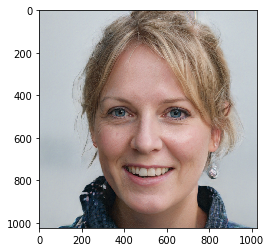

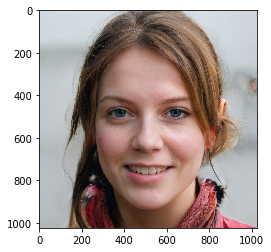

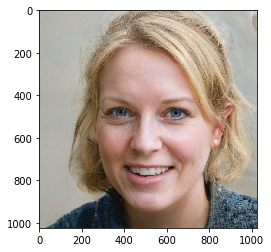

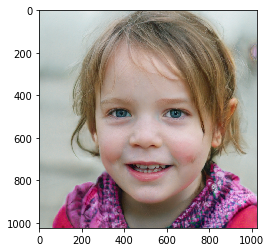

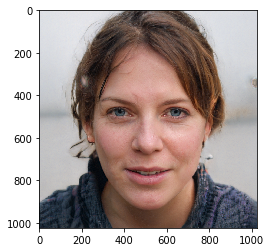

In [11]:
for i in range(10):
    new_latent = latent_vector + (rnd.randn(num_imgs, Gs.input_shape[1])*0.003)
    pred_img = Gs.run(new_latent, None, truncation_psi=0.7, randomize_noise=True, output_transform=fmt)
    plt.figure()
    plt.imshow(pred_img[0])

# Modify the Graph to make the inputs trainable

In [11]:
add_input_noise = True
noise_factor = 0.003
LATENT_SHAPE = (1,512)

## Make latent vector trainable and initialize its value

In [12]:
latents = tf.Variable(tf.random.normal(LATENT_SHAPE), name="learned_latent")
#latents = tf.Variable(latent_vector, name="learned_latent")

In [13]:

if add_input_noise:
    rand_latents = tf.add(latents, tf.random.normal(latents.shape, stddev=noise_factor))
    dlatents = Gs.components.mapping.get_output_for(rand_latents, None, is_validation=True)
else:
    dlatents = Gs.components.mapping.get_output_for(latents, None, is_validation=True)
images = Gs.components.synthesis.get_output_for(dlatents, is_validation=True, randomize_noise=True)
scale_factor = tf.constant(255/2)
shift_factor = tf.constant(0.5 - -1 * (255/2), dtype=tf.float32)


images_out = tf.add(tf.multiply(tf.cast(images, tf.float32), scale_factor), shift_factor)
images_out_int = tf.saturate_cast(images_out, tf.uint8)
images_transposed = tf.transpose(images_out_int, [0, 2, 3, 1])
init_latent = tf.initializers.variables([latents])

## Define Comparison Operation

In [14]:
# resize = tf.keras.backend.resize_images(images_out, 96, 96, 'channels_last')
# out_grad = tf.gradients(resize, latents)

In [15]:
compare_img_in = tf.placeholder(tf.float32, shape=(None,3,1024,1024), name='compare_img')
compare_img_transposed = tf.saturate_cast(tf.transpose(compare_img_in, [0, 3, 1, 2]), tf.uint8)
dist = tf.sqrt(tf.to_float(tf.reduce_sum(tf.squared_difference(compare_img_in, images_out))), name='dist_op')

In [16]:
# tf.keras.backend.resize_images(img_in, x, y, 'channels_last')
# base_model_path = '/home/kyle/Documents/senior_project/senior_capstone_group37/facial_recognition/SAVED_MODELS/nn4.small2.v1.h5'
# facenet_model = model_utils.FaceNet96()
# facenet_model.load_weights(base_model_path)
# facenet_model.summary()
print(images_out)
print(compare_img_in)
inception = misc.load_pkl('https://drive.google.com/uc?id=1MzTY44rLToO5APn8TZmfR7_ENSe5aZUn') # inception_v3_features.pkl
inception_output = inception.get_output_for(images_out)
comp_inception_out = inception.get_output_for(compare_img_in)
# feat_dist = tf.sqrt(tf.to_float(tf.reduce_sum(tf.squared_difference(inception_output, comp_inception_out))), 
#                                 name='feat_dist_op')
feat_dist = tf.to_float(tf.reduce_sum(tf.abs(tf.subtract(inception_output, comp_inception_out))), 
                                name='feat_dist_op')


Tensor("Add_1:0", shape=(1, 3, 1024, 1024), dtype=float32)
Tensor("compare_img:0", shape=(?, 3, 1024, 1024), dtype=float32)


## Setup Optimizer

In [17]:
optimizer = tf.train.AdamOptimizer(learning_rate=0.0001)
# train_step = optimizer.minimize(dist, var_list=(latents))
train_step = optimizer.minimize(feat_dist, var_list=(latents))

init_opt = tf.initializers.variables(optimizer.variables())

## Initialize new variables

In [18]:
tf.keras.backend.get_session().run(init_latent) # Initialize latent variables
tf.keras.backend.get_session().run(init_opt) # Initialize training variables

## Setup Comparison Image

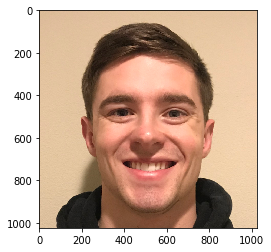

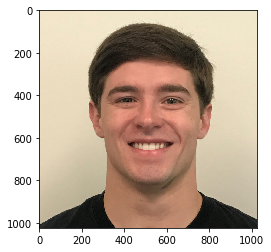

In [19]:
cmp_img = np.array(cv2.cvtColor(cv2.imread('/home/kyle/Downloads/kyle_passport_square.png'),
                                cv2.COLOR_BGR2RGB),
                                dtype=np.float32)
cmp_img2 = np.array(cv2.cvtColor(cv2.imread('/home/kyle/Downloads/kyle_id.png'),
                                cv2.COLOR_BGR2RGB),
                                dtype=np.float32)
cmp_img = cv2.resize(cmp_img, (1024,1024))
cmp_img2 = cv2.resize(cmp_img2, (1024,1024))
#png_filename = os.path.join(config.result_dir, 'cmp_img1' +'.png')
#PIL.Image.fromarray(cmp_img, 'RGB').save(png_filename)
plt.figure()
plt.imshow(np.array(cmp_img, dtype=np.uint8))
plt.figure()
plt.imshow(np.array(cmp_img2, dtype=np.uint8))


In [20]:
# Combine images into single array
cmp_imgs = np.array((cmp_img, cmp_img2))
print(cmp_imgs.shape)

(2, 1024, 1024, 3)


In [21]:
#grad_output = tf.keras.backend.get_session().run(out_grad, feed_dict=feed_image_dict)

In [22]:
##################################################################################
# Function: random_augmentation
# Description: Randomly augments an image given the parameters provided
# Parameters:
#            - img_in: image to be augmented 
#                   * should be in RGB channels last format 
#                   * we assume pixel values are between 0 and 255
#            - noise_delta: maximum random value added when adding random noise
#            - ang_range: maximum amount of angle to rotate the image
#            - shear_range: maximum amount of shearing to perform
#            - trans_range: maximum amount of translation to perform
# Returns: Augmented image
# Notes: Could also add the ability to randomly flip the image, and adjust brightness
##################################################################################
def random_augmentation(img_in, noise_delta=0.02, ang_range=10, shear_range=0, trans_range=2):
    # Randomly set: Brightness, rotation, translation, horrizontial flip, random noise
    # 50% chance image gets flipped
    img_shape = img_in.shape
    if np.random.randint(0, 1):
        img_in = np.fliplr(img_in)
    # Add random noise
    rnd_noise = np.random.normal(0, 255 * noise_delta, (img_shape[0], img_shape[1], 3))
    img_in = np.clip(img_in + rnd_noise,0,255)
    # Angle Range
    # Shear_range

    # Translation Range
    ang_rotate = np.random.uniform(ang_range) - ang_range / 2
    row, column, channel = img_in.shape
    Rot_M = cv2.getRotationMatrix2D((column / 2, row / 2), ang_rotate, 1)

    tr_x = trans_range * np.random.uniform() - trans_range / 2
    tr_y = trans_range * np.random.uniform() - trans_range / 2

    Trans_M = np.float32([[1, 0, tr_x], [0, 1, tr_y]])

    # Shear
    pts1 = np.float32([[5, 5], [20, 5], [5, 20]])

    pt1 = 5 + shear_range * np.random.uniform() - shear_range / 2
    pt2 = 20 + shear_range * np.random.uniform() - shear_range / 2

    pts2 = np.float32([[pt1, 5], [pt2, pt1], [5, pt2]])

    shear_M = cv2.getAffineTransform(pts1, pts2)

    image = cv2.warpAffine(img_in, Rot_M, (column, row))
    image = cv2.warpAffine(image, Trans_M, (column, row))
    image = cv2.warpAffine(image, shear_M, (column, row))

    return image
    

## Train the input values

In [23]:
train_iter = 200

display_freq = 10

sample_img_freq = 50
save_img_freq = 50
cmp_img_num = 0
use_augment = True
display_input_img = False
num_feed_imgs = 1

In [24]:
# Directory to save sample images from training 
train_sample_dir = os.makedirs(os.path.join(os.getcwd(), 'training_img_samples'), exist_ok=True)


In [26]:
# For the number of training iterations

for i in range(train_iter):
    # Setup Images
    #distance_val = tf.keras.backend.get_session().run(dist, feed_dict=feed_image_dict)
    if use_augment:
        if(num_feed_imgs == 1):
            aug_img = random_augmentation(cmp_imgs[cmp_img_num])
        else:
            aug_img = [random_augmentation(img_s) for img_s in cmp_imgs]
    else:
        if(num_feed_imgs == 1):
            aug_img = cmp_imgs[cmp_img_num]
        else:
            aug_img = cmp_imgs
    feed_image_dict = {
        compare_img_in: np.reshape(aug_img, (num_feed_imgs,3,1024,1024))
    }
    distance_val = tf.keras.backend.get_session().run(dist, feed_dict=feed_image_dict)
    #distance_val = tf.keras.backend.get_session().run(feat_dist, feed_dict=feed_image_dict)
    if(i % display_freq == 0):
        print("Iteration " + str(i) + " distance: " + str(distance_val))
    if(i % sample_img_freq == 0 and display_input_img):
        plt.figure()
        plt.imshow(np.array(aug_img, dtype=np.uint8))
    if(i % save_img_freq == 0):
        img_path = os.path.join(config.result_dir, 'cmp_img'+ str(cmp_img_num) + '_'+ str(i) +'.png')
        PIL.Image.fromarray(cmp_imgs[cmp_img_num], 'RGB').save(img_path)
    # Train on batch
    tf.keras.backend.get_session().run(train_step, feed_dict=feed_image_dict)


Iteration 0 distance: 189274.03
Iteration 10 distance: 188059.4
Iteration 20 distance: 190401.3
Iteration 30 distance: 193276.03
Iteration 40 distance: 198476.36
Iteration 50 distance: 191259.4
Iteration 60 distance: 186357.9
Iteration 70 distance: 191051.0
Iteration 80 distance: 197418.56
Iteration 90 distance: 193282.06
Iteration 100 distance: 187009.48
Iteration 110 distance: 189345.17
Iteration 120 distance: 191144.7
Iteration 130 distance: 196724.97
Iteration 140 distance: 196099.23
Iteration 150 distance: 198102.48
Iteration 160 distance: 189850.75
Iteration 170 distance: 186573.61
Iteration 180 distance: 190068.72
Iteration 190 distance: 190142.42


In [ ]:
# Alternate Training Via Stepping on Gradient Values

In [ ]:
for i in range(train_iter):
    # Setup Images
    #distance_val = tf.keras.backend.get_session().run(dist, feed_dict=feed_image_dict)
    if use_augment:
        if(num_feed_imgs == 1):
            aug_img = random_augmentation(cmp_imgs[cmp_img_num])
        else:
            aug_img = [random_augmentation(img_s) for img_s in cmp_imgs]
    else:
        if(num_feed_imgs == 1):
            aug_img = cmp_imgs[cmp_img_num]
        else:
            aug_img = cmp_imgs
    feed_image_dict = {
        compare_img_in: np.reshape(aug_img, (num_feed_imgs,3,1024,1024))
    }
    distance_val = tf.keras.backend.get_session().run(dist, feed_dict=feed_image_dict)
    #distance_val = tf.keras.backend.get_session().run(feat_dist, feed_dict=feed_image_dict)
    if(i % display_freq == 0):
        print("Iteration " + str(i) + " distance: " + str(distance_val))
    if(i % sample_img_freq == 0 and display_input_img):
        plt.figure()
        plt.imshow(np.array(aug_img, dtype=np.uint8))
    if(i % save_img_freq == 0):
        img_path = os.path.join(config.result_dir, 'cmp_img'+ str(cmp_img_num) + '_'+ str(i) +'.png')
        PIL.Image.fromarray(cmp_imgs[cmp_img_num], 'RGB').save(img_path)
    # Train on batch
    tf.keras.backend.get_session().run(train_step, feed_dict=feed_image_dict)

## Display the learned image

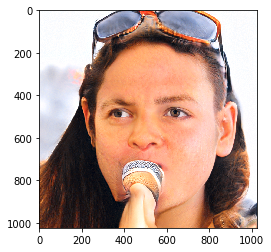

In [27]:
imgs_eval = tf.keras.backend.get_session().run(images_transposed)
imgs_eval = np.reshape(imgs_eval, (-1,1024,1024,3))
plt.figure()
plt.imshow(imgs_eval[0])

# Get the learned latent vector

In [20]:
latent_weights = tf.keras.backend.get_session().run(latents)
#print(latent_weights)

[[-1.40731148e-02 -1.71023253e-02  1.57172568e-02 -6.65772380e-03
  -1.50392903e-02  8.14777613e-03 -1.51892006e-02 -1.05437962e-02
  -7.54874526e-03 -1.86035186e-02 -1.53761720e-02 -1.56120947e-02
  -5.45302359e-03 -1.79003924e-02 -1.70852784e-02 -4.72581992e-03
  -1.40767619e-02 -1.84618533e-02 -1.85371842e-02  6.16160128e-03
  -1.46742743e-02 -9.20372643e-03  1.08360145e-02 -7.74046732e-03
   7.71133136e-03 -8.03913921e-03 -2.41501946e-02 -2.15067435e-02
  -2.06395090e-02 -6.86459150e-03 -1.91421229e-02 -7.87889492e-03
  -1.23804072e-02 -3.24683194e-03 -1.81787368e-02 -2.08562780e-02
  -1.48870563e-02 -1.38235213e-02 -6.87676156e-03  1.92058180e-03
  -1.07918167e-02 -4.96704271e-03 -3.77906524e-02 -1.41540878e-02
   7.65097153e-04 -1.99800613e-03 -2.42908541e-02 -8.57402012e-03
  -3.14904787e-02 -2.35716123e-02 -1.19658075e-02 -1.55990161e-02
  -1.91881321e-02 -2.64201430e-03 -1.80913694e-02 -3.56032662e-02
  -1.89215671e-02 -8.03541020e-03 -1.25751570e-02  1.03161298e-02
  -3.07068

# Save Learned Latent Vector

In [21]:
latent_dir = os.makedirs(os.path.join(os.getcwd(),'learned_latents'), exist_ok=True)
save_v_num = 0
np.save(os.path.join(latent_dir, 'cmp_img'+ str(cmp_img_num) + '_'+ str(img_v_num)'.npy'), latent_weights)

